# Economic Mode Plots 23-11-2020 to 29-11-2020

Notebook for comparing week long simulation of Economic MPC and RB  for HVAC and battery on the DRH

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
import pymysql
import datetime
#from datetime import datetime
import time
from sklearn.metrics import mean_squared_error

In [2]:
dt = 1/3

def mpc_energy_df(mpc_results):
    mpc_energy = mpc_results['2020-11-23':'2020-11-29'][['p_load', 'pv', 'p_hvac', 'p_im', 'p_ex', 'p_ch', 'p_dis', 
                      'cost', 'payment']].resample('d').sum()
    
    mpc_energy[['p_load', 'pv', 'p_im', 'p_ex', 'p_ch', 'p_dis','p_hvac']] = (mpc_energy[['p_load', 'pv', 'p_im', 'p_ex', 'p_ch', 'p_dis','p_hvac']])/(1000)*dt
    
    mpc_energy.loc['Total'] = mpc_energy.sum()
    
    #print(mpc_energy)
    
    return mpc_energy

In [3]:
def mpc_thermal(mpc_results):
    
    mpc_thermal = mpc_results['2020-11-23':'2020-11-29'][['p_hvac', 'phi_h_cool']].resample('d').sum()
    mpc_thermal[['p_hvac']] = (mpc_thermal[['p_hvac']]/(1000))*dt
    mpc_thermal[['phi_h_cool']] = -(mpc_thermal[['phi_h_cool']])*dt
    mpc_thermal['COP'] = (mpc_thermal['phi_h_cool']/mpc_thermal['p_hvac'])/0.6
    mpc_thermal['RMSE'] = [np.sqrt(mean_squared_error(mpc_results.loc[date.strftime("%Y-%m-%d")]['T_i'], mpc_results.loc[date.strftime("%Y-%m-%d")]['set_point'])) for date in mpc_thermal.index]
    
    mpc_thermal.loc['Total'] = mpc_thermal.sum()
    
    #print(mpc_thermal)
    
    return mpc_thermal
    

In [4]:
def plot_thermal_combined2(mpc_data, rbc_data):
    
    sns.set(font_scale=1.35, rc={'figure.figsize':(12,5)})
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    matplotlib.rcParams['font.family'] = 'Abyssinica SIL'
    
    fig, ax = plt.subplots(2, sharex=True)
    ax[0].set_ylabel('Temperature ($^\circ$C)')
    ax[0].set_ylim(15,45)
    ax[0].set_xlim(mpc_data.index[0],mpc_data.index[-1])
    ax[0].plot(mpc_data.index, mpc_data['T_i'], color='red', lw=2, ls='--')
    ax[0].plot(mpc_data.index, rbc_data['T_i'], color='black', lw=2, ls=(0, (3, 1, 1, 1, 1, 1)))
    ax[0].plot(mpc_data.index, mpc_data['t_ext'], color='green', ls='-.')
    #ax[0].plot(mpc_data.index, mpc_data['t_bed'])
    ax[0].plot(mpc_data.index, mpc_data['set_point'], color='grey')
    ax[0].legend(['MPC $T_i^i$', 'RBC $T_i^i$', '$T_a$', 'Set Point'], loc="upper left", ncol=4)
    
    
    
    #Plot Results
    
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Cooling (kW) \n Solar Irradiance (kW/m$^2$)')
    ax[1].set_ylim(0,15)
    #ax1.plot(df_results.index, df_results['phi_h_heat'], color='red')
    ax[1].plot(mpc_data.index, -mpc_data['phi_h_cool'], color='red', alpha=0.75, )
    ax[1].plot(mpc_data.index, -rbc_data['phi_h_cool'], color= 'black', ls=(0, (3, 1, 1, 1, 1, 1)))
    ax[1].plot(mpc_data.index, mpc_data['ghi']/1000, color='blue', ls='--')
    ax[1].legend(['MPC $\Phi_i^c$', 'RPC $\Phi_i^c$', 'GHI'], loc="upper left", ncol=3)



    fig.tight_layout()
    fig.set_figheight(7.5)
    fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
    #ax.grid()
    
    #plt.savefig('thermal_mpc_rbc.pdf', bbox_inches='tight')
    ax[0].autoscale(enable=True, axis='x', tight=True)
    ax[1].autoscale(enable=True, axis='x', tight=True)
    plt.show()

In [5]:
def plot_electrical3(df_results, sim):
    fig = plt.figure(figsize=(12,8))
    
    gs=GridSpec(3,1) # 2 rows, 3 columns

    ax1=fig.add_subplot(gs[0,0]) # First row, first column
    ax2=fig.add_subplot(gs[1:,0]) # First row, second column

    
    load =  ax2.plot(df_results.index, df_results['load'], label='$p_i^l$', lw=1, color='red', ls=(0, (3, 1, 1, 1)))
    pv =  ax2.plot(df_results.index, df_results['pv'], label='$p_i^p$', lw=1, color='blue', ls=(0, (5, 5)))
    im =  ax2.plot(df_results.index, df_results['p_im'], label='$p_i^i$', lw=1, color='grey', ls='-.')
    ex =  ax2.plot(df_results.index, df_results['p_ex'], label='$p_i^e$', lw=1, color='orange', ls=(0, (3, 1, 1, 1, 1, 1)))
    ch =  ax2.plot(df_results.index, df_results['p_ch'], label='$p_i^c$', lw=1.5,color='black', ls='dotted')
    dis =  ax2.plot(df_results.index, df_results['p_dis'], label='$p_i^d$', lw=1, color='green')
    hvac = ax2.plot(df_results.index, df_results['p_hvac'], label='$p_i^h$', lw=1, color='purple', ls=(0, (5, 1)))
    ax2.set_ylim(-6000,12000)
     
    soc = ax1.plot(df_results.index, df_results['soc'], label='$SoC$', lw=1, color='blue', ls='--')
    ax1.set_ylim(-10,120)
    
    ax3 = ax1.twinx()
    ax3.set_ylabel('Cost ($/kWh)')
    ax3.set_ylim(0,0.4)
    tou = ax3.plot(df_results.index, df_results['tou'], label='$ToU$', lw=1, color='red',)
    ax3.grid()
    
    ax2.set_xlabel('Date')
    ax1.set_ylabel('SoC (%)')
    ax1.get_shared_x_axes().join(ax1, ax2)
    ax1.set_xticklabels([])
    ax2.set_ylabel('Power (W)')
    
    ax2.legend(loc="upper left", ncol=7)
    ax1.legend(loc="upper left")
    ax3.legend(loc="upper right")
    ax1.autoscale(enable=True, axis='x', tight=True)
    
    #plt.savefig(f'{sim}_electrical_economic.pdf', bbox_inches='tight')

In [6]:
mpc_01 = pd.read_csv('CSV/T_SetCost_50-10_PhvacCost_01.csv', index_col=0)
mpc_01.index = pd.to_datetime(mpc_01.index, format='%Y-%m-%d %H:%M:%S')

In [7]:
mpc_025 = pd.read_csv('CSV/T_SetCost_50-10_PhvacCost_025.csv', index_col=0)
mpc_025.index = pd.to_datetime(mpc_025.index, format='%Y-%m-%d %H:%M:%S')

In [8]:
mpc_1 = pd.read_csv('CSV/T_SetCost_50-10_PhvacCost_1.csv', index_col=0)
mpc_1.index = pd.to_datetime(mpc_1.index, format='%Y-%m-%d %H:%M:%S')

In [9]:
rbc = pd.read_csv('CSV/RBC_Results.csv', index_col=0)
rbc.index = pd.to_datetime(rbc.index, format='%Y-%m-%d %H:%M:%S')
rbc['soc'] = (rbc['soc']/13.8)*100

In [10]:
#mpc_energy(mpc_01)

In [11]:
mpc_elec_data = mpc_energy_df(mpc_025)
mpc_elec_data.round(2).to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n{} &  p\\_load &      pv &  p\\_hvac &   p\\_im &    p\\_ex &   p\\_ch &  p\\_dis &   cost &  payment \\\\\n\\midrule\n2020-11-23 00:00:00 &   29.64 &   12.16 &    7.56 &  11.93 &    0.00 &  -7.12 &  12.67 &   2.50 &     0.00 \\\\\n2020-11-24 00:00:00 &   30.08 &   52.71 &    8.21 &   6.31 &  -23.25 & -14.94 &   9.25 &   1.48 &    -2.56 \\\\\n2020-11-25 00:00:00 &   28.01 &   39.98 &    5.93 &   3.63 &  -16.07 & -12.72 &  13.20 &   1.02 &    -1.77 \\\\\n2020-11-26 00:00:00 &   31.25 &   58.08 &    9.17 &   3.82 &  -28.97 & -14.40 &  12.73 &   1.07 &    -3.19 \\\\\n2020-11-27 00:00:00 &   31.21 &   53.09 &    9.43 &   4.97 &  -25.89 & -14.25 &  13.30 &   1.25 &    -2.85 \\\\\n2020-11-28 00:00:00 &   43.21 &   49.21 &   21.13 &   8.19 &  -13.93 & -15.45 &  15.19 &   1.81 &    -1.53 \\\\\n2020-11-29 00:00:00 &   51.92 &   34.27 &   30.29 &  22.62 &   -2.69 & -17.42 &  15.14 &   4.46 &    -0.30 \\\\\nTotal               &  245.34 &  299.50 &   91.7

In [12]:
rbc_elec_data = mpc_energy_df(rbc)
rbc_elec_data.round(2).to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n{} &  p\\_load &      pv &  p\\_hvac &   p\\_im &    p\\_ex &   p\\_ch &  p\\_dis &   cost &  payment \\\\\n\\midrule\n2020-11-23 00:00:00 &   33.07 &   12.16 &   10.99 &  14.42 &    0.00 &  -5.47 &  11.97 &   3.52 &     0.00 \\\\\n2020-11-24 00:00:00 &   31.54 &   52.71 &    9.67 &   8.07 &  -23.15 & -15.11 &   9.02 &   1.95 &    -2.55 \\\\\n2020-11-25 00:00:00 &   29.57 &   39.98 &    7.49 &   5.12 &  -14.96 & -14.39 &  13.82 &   1.37 &    -1.65 \\\\\n2020-11-26 00:00:00 &   32.61 &   58.08 &   10.53 &   4.86 &  -30.57 & -13.21 &  13.45 &   1.30 &    -3.36 \\\\\n2020-11-27 00:00:00 &   31.64 &   53.09 &    9.85 &   7.89 &  -26.95 & -14.64 &  12.26 &   2.12 &    -2.96 \\\\\n2020-11-28 00:00:00 &   44.58 &   49.21 &   22.50 &   6.42 &  -16.16 & -13.16 &  18.27 &   1.75 &    -1.78 \\\\\n2020-11-29 00:00:00 &   52.57 &   34.27 &   30.94 &  23.02 &   -4.17 & -12.59 &  11.93 &   5.30 &    -0.46 \\\\\nTotal               &  255.58 &  299.50 &  101.9

In [13]:
#mpc_energy(mpc_1)

In [14]:
#mpc_thermal(mpc_01)

In [15]:
mpc_025_thermal = mpc_thermal(mpc_025)
mpc_025_thermal.round(2)

,p_hvac,phi_h_cool,COP,RMSE
2020-11-23 00:00:00,7.56,15.35,3.38,0.50
2020-11-24 00:00:00,8.21,16.72,3.39,0.54
2020-11-25 00:00:00,5.93,12.53,3.52,0.49
2020-11-26 00:00:00,9.17,17.67,3.21,0.45
2020-11-27 00:00:00,9.43,19.40,3.43,0.56
2020-11-28 00:00:00,21.13,32.94,2.60,0.59
2020-11-29 00:00:00,30.29,49.44,2.72,0.64
Total,91.73,164.03,22.25,3.78


In [16]:
rbc_thermal = mpc_thermal(rbc)
rbc_thermal.round(2)

,p_hvac,phi_h_cool,COP,RMSE
2020-11-23 00:00:00,10.99,22.43,3.40,0.77
2020-11-24 00:00:00,9.67,19.82,3.42,0.65
2020-11-25 00:00:00,7.49,15.90,3.54,0.64
2020-11-26 00:00:00,10.53,20.41,3.23,0.80
2020-11-27 00:00:00,9.85,20.26,3.43,0.57
2020-11-28 00:00:00,22.50,34.93,2.59,0.40
2020-11-29 00:00:00,30.94,50.48,2.72,0.59
Total,101.98,184.23,22.32,4.41


In [17]:
#mpc_thermal(mpc_1)

In [18]:
mpc_plot = mpc_025['2020-11-23':'2020-11-29']

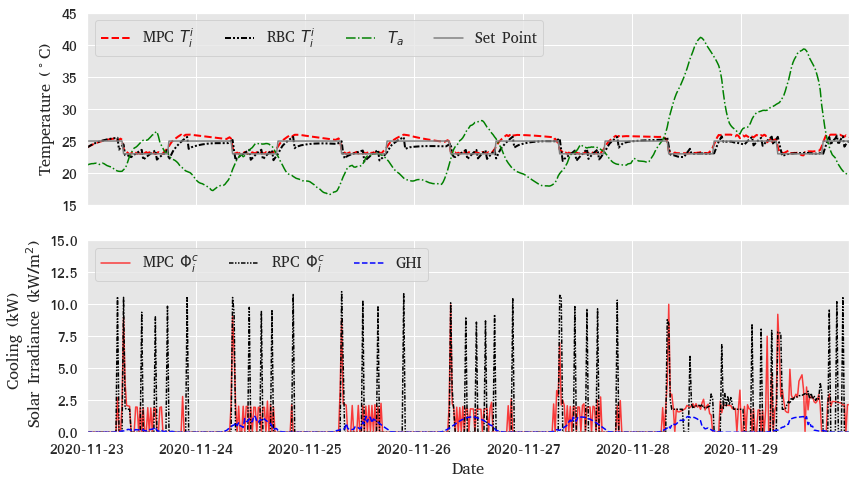

In [19]:
plot_thermal_combined2(mpc_plot, rbc)

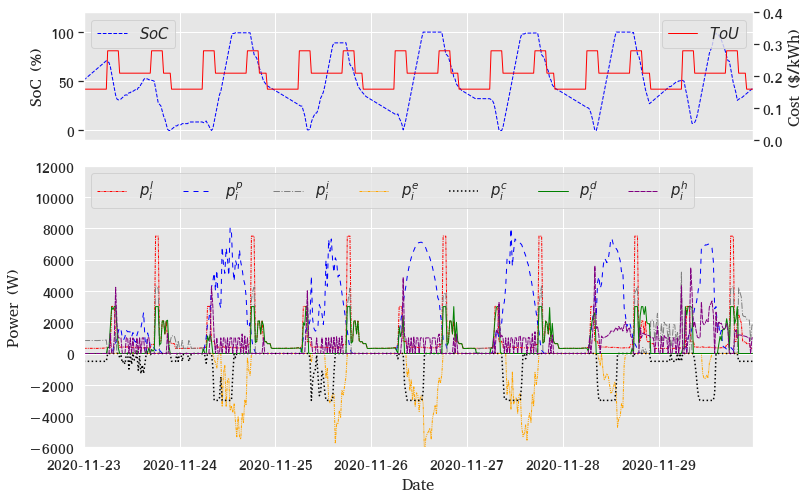

In [20]:
plot_electrical3(mpc_plot, sim='mpc')

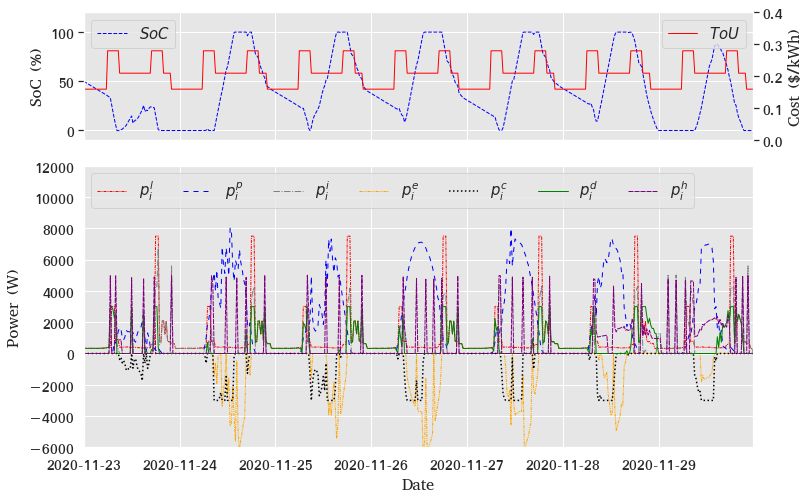

In [21]:
plot_electrical3(rbc, sim='rbc')